 # 変更点
- CustomerをLocationインスタンスの塊に変更
- insertion_locationを削除

# 問題例

## 問題例の作成

In [1]:
class TW():
    def __init__(self, s, e):
        """
        時間枠を表す構造体
        """
        self.s = s
        self.e = e

In [25]:
class Location():
    def __init__(self, number=None, coordinate=None, demand=None, loc_type=None, arrivetime=0, departuretime=0, tw=TW(0,0), penalty=0):
        """
        地点を表す構造体
        """
        self.number = number
        self.coordinate = coordinate
        self.demand = demand
        self.loc_type = loc_type
        self.arr = arrivetime
        self.dep = departuretime
        self.tw = tw
        self.penalty = penalty

In [26]:
class Customer():
    def __init__(self, number, dt, pickup_coordinate, delivery_coordinate, demand, tw, penalty):
        """
        customer : 顧客　(顧客を表す数字, 需要が発生する時刻, 需要量, ピックアップ地点を表す座標, デリバリー地点を表す座標, 時間枠, 時間枠の逸脱費用)
            number : 顧客を表す数字
            dt : 需要が発生する時刻
            pickup : ピックアップ地点を表すLocationインスタンス
            delivery : デリバリー地点を表すLocationインスタンス
            penalty : 時間枠の逸脱費用
        """
        self.number = number
        self.dt = dt
        self.demand = demand
        self.pickup = Location(number, pickup_coordinate, -demand, "p")
        self.delivery = Location(number, delivery_coordinate, demand, "d", tw, penalty)
        self.penalty = penalty

In [27]:
class Piecewiseinterval():
    def __init__(self, interval):
        self.start = interval[0]
        self.end = interval[1]

In [28]:
class Capacityfunctype():
    def __init__(self, capacities, intervals):
        self.capacities = capacities
        self.intervals = [Piecewiseinterval(i) for i in intervals]

In [29]:
class Capacity():
    def __init__(self, capacities=(0,), intervals=[(0,0)]):
        """
        車両の容量を表す区分線型関数
        inputs :
            capacity : ある時刻での車両の容量を表す数字を要素にもつリスト
        """
        #self.func = Capacityfunctype((0,), [(0, 0)])
        self.capacities = capacities
        self.intervals = intervals
    def setfunc(self, capacities, intervals):
        """
        与えられたcapacities(タプル)とpiecewiseintervals(タプル)を元にして，新たに関数を定義する
        """
        #self.func = Capacityfunctype(capacities, intervals)
        self.capacities = capacities
        self.intervals = [Piecewiseinterval(i) for i in intervals]
    def getfuncval(self, x):
        #for i, t in enumerate(self.func.intervals):
            #if t.start <= x <= t.end:
                #return self.func.capacity[i]
        for i, t in zip(self.capacities, self.intervals):
            if t.start <= x <= t.end:
                return i

In [30]:
class Currnetlocation():
    def __init__(self, coordinate, customer_idx):
        """
        車両の現在位置を表す構造体
        """
        self.coordinate = coordinate
        self.idx = customer_idx

In [31]:
class Vehicle():
    def __init__(self, number, capacity, tour):
        """
        vehicles : 配送車 (配送車を表す数字, 容量, 巡回路, 各顧客の発着時間))
            number : 配送車を表す数字
            capacity : 容量
            tour : 巡回路
            #plan : 各顧客の発着時間
        """
        self.number = number
        self.capacity = Capacity()
        self.tour = tour
        self.currentlocation = Location(-1, (0,0))#Currnetlocation((0, 0), -1) # 最初はデポから出発 & 最後はデポに帰る
        #self.plan = plan

In [32]:
class Instance():
    def __init__(self):
        """
        service_period : 全体の勤務時間
        customers : 客の集合
        vehicles : 配送車の集合
        """
        self.service_period = 0
        self.customers = []
        self.vehicles = []
    def example(self):
        """
        inputs :
            None
        outputs :
            None
        parameters :
            n : 顧客の数
            r : 顧客の座標の範囲
            dt : 需要が発生する時刻
            lower_dem : 需要量の最小値
            upper_dem : 需要量の最大値
            demand : 需要量
            tw : 顧客の時間枠
            penalty : 時間枠の逸脱費用
            n_vehicles : 配送車の数
            lower_cap : 配送車の容量の最小値
            capacity : 配送車の容量
            tour : 巡回路
        """
        import random
        random.seed(0)
        self.service_period = 30
        n = 3
        r = 10.0
        lower_dem = 1
        upper_dem = 10
        demands = 0
        for i in range(n):
            dt = random.randint(0, int(self.service_period*0.7))
            demand = random.uniform(lower_dem, upper_dem)
            p_x = random.uniform(-r, r)
            p_y = random.uniform(-r, r)
            d_x = random.uniform(-r, r)
            d_y = random.uniform(-r, r)
            s = random.uniform(0, self.service_period)
            e = random.uniform(s, self.service_period)
            tw = TW(s,e)
            penalty = 0.1
            c = Customer(i, dt, (p_x, p_y), (d_x, d_y), demand, tw, penalty)
            self.customers.append(c)
            demands += demand
        n_vehicles = random.randint(1, n)
        lower_cap = demands/2
        upper_cap = demands
        for v in range(n_vehicles):
            capacity = random.uniform(lower_cap, upper_cap)
            #upper_cap = demands - capacity
            depot = Location(-1, (0,0), 0, "depot")
            tour = [depot, depot]
            #plan = [(0,0), (self.service_period,)]
            v = Vehicle(v, capacity, tour)
            v.capacity.setfunc((capacity,), [(0, self.service_period)])
            self.vehicles.append(v)

In [33]:
instance = Instance()
instance.example()

In [34]:
print("全体の時間 : ", instance.service_period, "分")
print("顧客 : ")
for c in instance.customers:
    for var in vars(c):
        print("\t", var, " :", eval("c."+str(var)))
    print()
print("車両 : ")
for v in instance.vehicles:
    for var in vars(v):
        print("\t", var, " :\t", eval("v."+str(var)))
    print()

全体の時間 :  30 分
顧客 : 
	 number  : 0
	 dt  : 12
	 demand  : 7.821589626462722
	 pickup  : <__main__.Location object at 0x7f9d1ab32350>
	 delivery  : <__main__.Location object at 0x7f9d1ab32150>
	 penalty  : 0.1

	 number  : 1
	 dt  : 15
	 demand  : 4.222444372254895
	 pickup  : <__main__.Location object at 0x7f9d1ab4b4d0>
	 delivery  : <__main__.Location object at 0x7f9d1ab4b750>
	 penalty  : 0.1

	 number  : 2
	 dt  : 17
	 demand  : 9.845069284338878
	 pickup  : <__main__.Location object at 0x7f9d1ab4b290>
	 delivery  : <__main__.Location object at 0x7f9d1ab4b2d0>
	 penalty  : 0.1

車両 : 
	 number  :	 0
	 capacity  :	 <__main__.Capacity object at 0x7f9d1aa95210>
	 tour  :	 [<__main__.Location object at 0x7f9d1ab4bc50>, <__main__.Location object at 0x7f9d1ab4bc50>]
	 currentlocation  :	 <__main__.Location object at 0x7f9d1932a150>

	 number  :	 1
	 capacity  :	 <__main__.Capacity object at 0x7f9d1abb2050>
	 tour  :	 [<__main__.Location object at 0x7f9d1932a550>, <__main__.Location object a

In [35]:
instance.vehicles[0].capacity.capacities[0]

17.07146136114074

In [36]:
instance.vehicles[0].tour[0].number

-1

In [37]:
print('[', instance.vehicles[0].capacity.intervals[0].start, ',', instance.vehicles[1].capacity.intervals[0].end, ']')

[ 0 , 30 ]


In [38]:
instance.vehicles[0].capacity.getfuncval(30)

17.07146136114074

In [39]:
#顧客の需要の合計 < 配送車の容量の合計　となっているかチェック
print(
    sum(eval("c."+str(var)+".demand") for var in vars(c) for c in instance.customers if var=="pickup")
      <=
    sum(eval("v."+str(var) +".capacities[0]")  for var in vars(v) for v in instance.vehicles if var=="capacity")
)
#sum(map(lambda x : x[1], customers.values())) <= sum(map(lambda x : x[0], vehicles.values()))

True


## 問題例の描画

あるリクエストに対し，●がピックアップ地点，▲がデリバリー地点


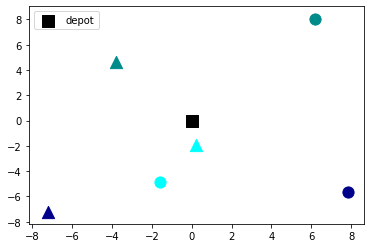

In [40]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# 顧客の情報の展開
p, d = [], []
for c in instance.customers:
    for var in vars(c):
        if var == "pickup":
            p.append(eval("c."+str(var)+".coordinate"))
        elif var == "delivery":
            d.append(eval("c."+str(var)+".coordinate"))
p_xs, p_ys = zip(*p)
d_xs, d_ys = zip(*d)

# 顧客の色の選択と，デポの描画
colors =  list(matplotlib.colors.cnames.keys())
plt.scatter(0, 0, marker=",", color="black", s=150, label="depot")

for i in range(len(instance.customers)):
    color = colors[i+20]
    p_x, p_y, d_x, d_y = p_xs[i], p_ys[i], d_xs[i], d_ys[i]
    # ピックアップ地点
    plt.scatter(p_x, p_y, marker=".", color=color, s=500)
    # デリバリー地点
    plt.scatter(d_x, d_y, marker="^", color=color, s=150)

# 顧客の描画
print("あるリクエストに対し，●がピックアップ地点，▲がデリバリー地点")
plt.legend()
plt.show()

# 問題を解く

## 配送計画

### 1. Constructive method

- Constructive methodでは，i分ごとにCheapest insertion methodを行う．
- Cheapest insertion methodでは，tourにリクエストを挿入するのにかかるコストを元に，現在のtourにリクエストを挿入する．
- リクエストをスラックタイムの少ない順に並べてから挿入を行う．
- コストはそのリクエストを挿入することによっておこるルートの増加量とスラックタイムの減少量を元に算出する．

### 2. Local Search

- LS

## スケジューリング

### Drive first strategy
- なるはやで行く．
- 客のところで待つのも可．

In [182]:
class Methods():
    def __init__(self):
        self.velocity = 1
        self.alpha = 0.1
    def set_var(self, instance):
        self.service_period = instance.service_period
        self.customers = instance.customers
        self.vehicles = instance.vehicles
    def solve(self):
        """
        i分ごとに実行可能解を作る．（Cheapest insertion methodを行う + DFを行う．）
        parameters :
            i : Cheapest insertion methodを行う時間間隔（整数）
        """
        # 需要が発生する時刻が早い順に並べ替える
        sorted_cs = sorted(self.customers, key=lambda customer : customer.dt)
        # i分ごとにconstructiveを実行
        i = 5
        self.time = sorted(set(range(0, self.service_period, i))|{self.service_period})
        self.now = -1
        while (sorted_cs != []) and (len(sorted_cs) != 0):
            self.now += 1
            # 前回挿入を行った時から現在までの間に溜まったリクエスト
            self.new_reqs = []
            for idx, customer in enumerate(sorted_cs):
                if customer.dt <= self.time[self.now]:
                    self.new_reqs.append(customer)
                    if idx == len(sorted_cs)-1:
                        sorted_cs = []
                else:
                    sorted_cs = sorted_cs[idx:]
                    break
            # Cheapest insertionの実行
            self.constructive()
            ################print([v.tour for v in self.vehicles])
    def constructive(self):
        """
        Cheapest insertion methos : tourを前から順番に見ていき,最も挿入するコストがかからないところにリクエストを挿入
        variables :
            #insertion_locations : リクエストをtourに挿入する場所の辞書（keyが顧客の番号，valueが挿入する場所）
        """
        if self.new_reqs != []:
            # tourを前から順番に見ていき，最も挿入するコストがかからないところを見つける
            # 各車両のtourにリクエストを挿入
            self.insert()
    def insert(self):
        """
        新しいリクエストたち(new_reqs)を挿入する場所を決め,tourに挿入する
        新しいリクエストの発着時間を決める
        variables :
            min_cost_p, min_cost_d : あるリクエストを巡回路に挿入するときに便宜上必要なコスト
        """
        # 新しいリクエストを順番に見ていく
        for new_req in self.new_reqs:
            self.vehicle_n = 0
            self.point_p, self.point_d = 0, 0
            self.cost_p, self.cost_d = 0, 0
            self.min_cost_p, self.min_cost_d = 1e+10, 1e+10
            # 各車両
            for vehicle in self.vehicles:
                # 車両vehicleのtour
                v_tour = self.traverse_tour(vehicle, self.time[self.now])
                for idx, location in enumerate(v_tour):
                    nextlocation = v_tour[idx+1]
                    # コストの計算
                    self.calculate_cost(new_req, vehicle, location.coordinate, nextlocation.coordinate)
                    # 最小コストの更新
                    self.update_mincost(vehicle, idx)
                    
            assert self.point_p <= self.point_d, "ピックアップよりも前にデリバリーされている"
                
            # tourに，新しいリクエストたち(new_reqs)のLocationインスタンス(Customerインスタンスをピックアップとデリバリーに分解したもの)を挿入する
            self.update_tour(new_req)
            # DFの実行
            self.DF(self.vehicles[self.vehicle_n], new_req)
    def traverse_tour(self, vehicle, nowtime):
        """
        車両の現在地(self.currentlocation)よりも後にある顧客．つまり，まだ訪問していない顧客の配列を返す
        """
        traverse_tour = []
        idx = vehicle.currentlocation.number
        #####print("現在時刻 : ", self.time[self.now])
        #####print("現在地(顧客の番号) : ", idx)
        for i, nowlocation in enumerate(vehicle.tour[idx:-2]):
            if nowlocation.dep <= nowtime:
                nextlocation = vehicle.tour[i+1]
                previouslocation = vehicle.tour[i-1]
                # 現在地の更新
                self.update_currentlocation(vehicle, i, nowtime, previouslocation, nowlocation, nextlocation)
                # traverse_tourに代入
                traverse_tour = [vehicle.currentlocation] + vehicle.tour[i:-1]
                break
        return traverse_tour
    def update_currentlocation(self, vehicle, i, nowtime, previouslocation, nowlocation, nextlocation):
        dx = nextlocation.coordinate[0]-nowlocation.coordinate[0] or 1
        dy = nextlocation.coordinate[1]-nowlocation.coordinate[1] or 1
        diagonal = (dx**2+dy**2)**(1/2) or 1
        x_per_min = dx/(self.velocity*(dx/diagonal))
        y_per_min = dy/(self.velocity*(dy/diagonal))
        vehicle.currentlocation.idx =  i
        vehicle.currentlocation.coordinate = (nowlocation.coordinate[0]+x_per_min*(nowtime - previouslocation.dep), nowlocation.coordinate[1]+y_per_min*(nowtime - previouslocation.dep))
    def calculate_cost(self, new_req, vehicle, location, nextlocation):
        self.cost_p = (1-self.alpha)*self.f(location, new_req.pickup.coordinate, nextlocation) + self.alpha*self.g(new_req.pickup.coordinate, new_req.delivery.coordinate) + self.i(vehicle.capacity.getfuncval(self.time[self.now]), new_req.demand)
        self.cost_d = (1-self.alpha)*self.f(location, new_req.delivery.coordinate, nextlocation) + self.alpha*self.g(new_req.pickup.coordinate, new_req.delivery.coordinate) + self.h(location, new_req)
    def update_mincost(self, vehicle, idx):
        if self.cost_p < self.min_cost_p:
            self.min_cost_p = self.cost_p
            self.point_p = idx
            self.vehicle_n = vehicle.number
        if (self.cost_d < self.min_cost_d) and (self.point_p <= self.point_d):
            self.min_cost_d = self.cost_p
            self.point_d = idx
            self.vehicle_n = vehicle.number
    def f(self, location, new_location, nextlocation):
        """
        巡回路の距離の増加を計算する
        locationとnew_locationのユークリッド距離 + new_locationとlocation+1のユークリッド距離
        """
        return self.distance(location, new_location) + self.distance(new_location, nextlocation)
    def distance(self, p, q):
        return ((p[0]-q[0])**2+(p[1]-q[1])**2)**(1/2)
    def g(self, p, d):
        """
        スラックタイムの減少を計算する
        サービス可能時間 - ピックアップ地点からデリバリー地点へ直接移動するのにかかる時間
        """
        slacktime = 0
        return slacktime - self.distance(p, d)/self.velocity
    def h(self, alocintour, new_req):
        """
        時間枠の違反度を計算する
        tour内の地点を出発する時刻 + tour内の地点からリクエストのデリバリー地点までにかかる時間 <= 顧客の時間枠の締め切り時刻　→　ペナルティ 0
        それ以外　→ ペナルティ (顧客の時間枠の締め切り時刻 - tour内の地点からリクエストのデリバリー地点までにかかる時間)*そのリクエストの時間枠違反にかかる単位時間あたりコスト
        """
        overtime = new_req.delivery.tw.e - self.distance(alocintour, new_req.delivery.coordinate)
        penalty = 0
        if overtime > 0:
            penalty = overtime*new_req.penalty
        return penalty
    def i(self, capacity, demand):
        """
        車両の容量制約が満たされているか判断する
        parameters :
            違反した場合に返す値
        """
        if demand > capacity:
            return 1e+100
        return 0
    def update_tour(self, new_req):
        """
        tourにリクエストのピックアップ地点，デリバリー地点を追加
        """
        idx_p, idx_d = self.point_p, self.point_d
        tour = self.vehicles[self.vehicle_n].tour
        self.vehicles[self.vehicle_n].tour = tour[:idx_p+1] + [new_req.pickup] + tour[idx_p+1:idx_d+1] + [new_req.delivery] + tour[idx_d+1:]
    def DF(self, vehicle, new_req):
        """
        各車両の巡回路(tour)から顧客の発着時間を決定
        巡回路に新たなリクエストが入れられた車両の容量を減らす
        """
        # 発着時間の決定
        for i, now in enumerate(vehicle.tour):
            if i != 0:
                prev = vehicle.tour[i-1]
                now.arr = prev.dep + self.distance(prev.coordinate, now.coordinate)
                now.dep = prev.dep + self.distance(prev.coordinate, now.coordinate) + (now.tw.s-now.arr)*((now.tw.s-now.arr)<0)#時間枠の始まりよりも前に着いたら待機
        # 車両の容量を減らす
        # self.vehicles[self.vehicle_n].tour[self.point_p].depからself.vehicles[self.vehicle_n].tour[self.point_d].arrまでの間の車両の容量を減らす
        self.modifycapacity(new_req)
    def modifycapacity(self, new_req):
        """
        車両の容量を表す区分線形関数に変更を加える．
        """
        s, e = self.vehicles[self.vehicle_n].tour[self.point_p].dep, self.vehicles[self.vehicle_n].tour[self.point_p].arr
        capacities, intervals = self.vehicles[self.vehicle_n].capacity.capacities, self.vehicles[self.vehicle_n].capacity.intervals
        flag = False
        for idx,v in enumerate(zip(capacities, intervals)):
            if v[1].start <= s <= v[1].end:
                flag = True
                del intervals[idx]
                intervals = intervals[:idx+1] + [(v[1].start, s)] + [(s, v[1].end)] + intervals[idx+1:]
                capacities = capacities[:idx+1] + (v[0]-new_req.demand) + capacities[idx+1:]
            elif v[1].start <= e <= v[1].end:
                flag = False
                del intervals[idx]
                intervals = intervals[:idx+1] + [(v[1].start, e)] + [(e, v[1].end)] + intervals[idx+1:]
                capacities = capacities[:idx+1] + [v[0]-new_req.demand] + capacities[idx+1:]
            if flag:
                v[0] -= new_req
        self.vehicles[self.vehicle_n].capacity.setfunc(capacities, intervals)

In [183]:
l1 = [1,2,3]
l2 = [10, 20, 30]
idx = 1
for a,b in enumerate(zip(l1, l2)):
    print(a)
    print(b)
    if a == idx:
        l1 = l1[:idx+1] + [0] + l1[idx+1:]
        l2 = l2[:idx+1] + [0] + l2[idx+1:]
    print(l1)
    print()

0
(1, 10)
[1, 2, 3]

1
(2, 20)
[1, 2, 0, 3]

2
(3, 30)
[1, 2, 0, 3]



In [184]:
l1

[1, 2, 0, 3]

In [185]:
l = [i for i in range(10)]
l = l[:4] + [100] + l[4:4] + [200] + l[4:]
l

[0, 1, 2, 3, 100, 200, 4, 5, 6, 7, 8, 9]

In [186]:
methods = Methods()
methods.set_var(instance)
print(methods.service_period)

30


In [187]:
print(methods.vehicles[0].number)

0


In [188]:
methods.solve()

self.point_p :  0
self.point_d :  0
self.point_p :  0
self.point_d :  0
self.point_p :  0
self.point_d :  0


In [192]:
print(methods.vehicles[0].tour)

[<__main__.Location object at 0x7f9d1ab4bc50>, <__main__.Location object at 0x7f9d1ab4b290>, <__main__.Location object at 0x7f9d1ab4b2d0>, <__main__.Location object at 0x7f9d1ab4b4d0>, <__main__.Location object at 0x7f9d1ab4b750>, <__main__.Location object at 0x7f9d1ab32350>, <__main__.Location object at 0x7f9d1ab32150>, <__main__.Location object at 0x7f9d1ab4b290>, <__main__.Location object at 0x7f9d1ab4b2d0>, <__main__.Location object at 0x7f9d1ab4b4d0>, <__main__.Location object at 0x7f9d1ab4b750>, <__main__.Location object at 0x7f9d1ab32350>, <__main__.Location object at 0x7f9d1ab32150>, <__main__.Location object at 0x7f9d1ab32350>, <__main__.Location object at 0x7f9d1ab32150>, <__main__.Location object at 0x7f9d1ab32350>, <__main__.Location object at 0x7f9d1ab32150>, <__main__.Location object at 0x7f9d1ab32350>, <__main__.Location object at 0x7f9d1ab32150>, <__main__.Location object at 0x7f9d1ab32350>, <__main__.Location object at 0x7f9d1ab32150>, <__main__.Location object at 0x7f